# Logistic Regression on Amazon Food review Dataset

Logistic regression is a supervied machine learning algorithm that can be used to predict polarity of reviews in amazon fine foods dataset obtained from kaggle. (https://www.kaggle.com/snap/amazon-fine-food-reviews)

In this ipython notebook,following steps are performed:
    1. Load cleaned data 
    2. Sample data based on timestamp
    3. Convert text to vector using one of the following methods
        a.bag of words
        b.tf-idf
        c.average word2vec
        d.tf-idf word2vec
    4. Apply Logistic Regression
        a. column standardize data
        b. divide data into test and train
        c. find the best alpha using
             i.grid search cross validation
             ii.random search cross validation
        d. Regularization
             i. L1 regularizer
             ii. L2 regularizer
        e. Predict the polarity of test samples using logistic regression
    5. Observe the effect of alpha (L1 regularisation) on sparsity
    6. Find feature importance
    7. Performance measurement
        a. accuracy
        b. confusion matrix
        c. presicion, recall and f1-score

1. Load data

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


#Using sqlite3 to retrieve data from sqlite file
con = sqlite3.connect(r'C:\Users\Admin\Downloads\final.sqlite')

#Read data from the sqlite file
data = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)




2.Sample Data

In [2]:
data.sort_values('Time',inplace=True,ascending=False)
sampled_data=data[:12000]

In [3]:
#We use 70% of data for training and 30% of data for test
import math
sampled_data.sort_values('Time',inplace=True,ascending=True) 

X_train =  sampled_data[:math.ceil(len(sampled_data)*.7)] 
X_test = sampled_data[math.ceil(len(sampled_data)*.3):]
y_train = sampled_data['Score'][:math.ceil(len(sampled_data)*.7)]
y_test =  sampled_data['Score'][math.ceil(len(sampled_data)*.3):]

3.Convert Text to vector

Bag Of Words

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer() 
bow_model = count_vect.fit(X_train['CleanedText'])
final_bow_train = bow_model.transform(X_train['CleanedText'])
final_bow_test = bow_model.transform(X_test['CleanedText'])

4.Apply Logistic Regression

a.Column standardize data

In [5]:
from sklearn.preprocessing import StandardScaler

normalised_bow_train = StandardScaler(with_mean=False).fit_transform(final_bow_train)
normalised_bow_test = StandardScaler(with_mean=False).fit_transform(final_bow_test)

c.Find the best Alpha using grid search cross validation

In [6]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression


In [7]:
l1 = LogisticRegression(penalty='l1')
l2=LogisticRegression(penalty='l2')

In [8]:

def grid_alpha(X_train,y_train,param,esti):
    grid = GridSearchCV(estimator = esti,param_grid=param ,cv = 10,n_jobs = 3)
    grid.fit(X_train, y_train)
    alphainverse = grid.best_params_
    optimal_alpha = alphainverse.get('C')
    print("best C = ", grid.best_params_)
    
    error = [(1-i) for i in grid.cv_results_['mean_test_score']]
    sns.set_style("darkgrid")
    plt.plot(param[0].get('C'), error)
    plt.title('Accuracy for different values of lambda')
    plt.xlabel('lambda value')
    plt.ylabel('Test Error')
    plt.show()
    
    
    return optimal_alpha

In [9]:
def randomsearch_alpha(X_train,y_train,param,esti):
    randm = RandomizedSearchCV(esti,param ,cv = 5,n_jobs = 3)
    randm.fit(X_train, y_train)
    alphainverse = randm.best_params_
    optimal_alpha = alphainverse.get('C')
    print("best C = ", randm.best_params_)
    print("Best Score on train data = ", randm.best_score_*100)
    


    param =[]
    for i in range(10):
        param.append(randm.cv_results_['params'][i]['C'])
    sorted_param = np.argsort(param)
    error = [(1-i)*100 for i in randm.cv_results_['mean_test_score']]
    l_values=[]
    err=[]
    for i in sorted_param:
        l_values.append(param[i])
        err.append(error[i])
    
    plt.plot(l_values, err)
    plt.title('Accuracy for different values of lambda')
    plt.xlabel('lambda value')
    plt.ylabel('Test Error')
    plt.show()
    
    return optimal_alpha

L1 regularization and finding alpha using grid search

best C =  {'C': 0.1}


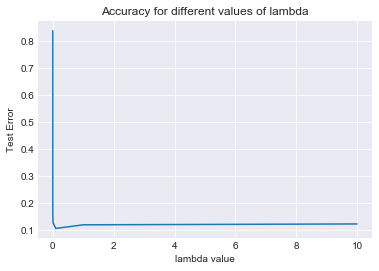

In [10]:
paramgrid = [{ 'C':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1]}]
optimalg = grid_alpha(normalised_bow_train,y_train,paramgrid,l1)

In [11]:
logreg = LogisticRegression(C = optimalg)

logreg.fit(normalised_bow_train,y_train)

predicted = logreg.predict(normalised_bow_test)

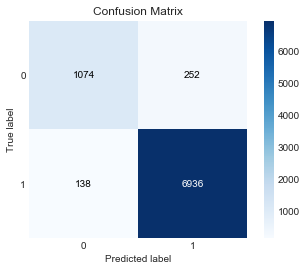

In [12]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_test ,predicted)

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [14]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

Accuracy on test set: 95.357%
Precision on test set: 0.965
Recall on test set: 0.980
F1-Score on test set: 0.973


L1 regularization and finding alpha using random search

best C =  {'C': 0.14956316965703742}
Best Score on train data =  89.30952380952381


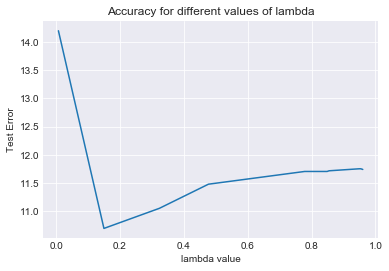

In [15]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
rand={'C':uniform()}
optimall=randomsearch_alpha(normalised_bow_train,y_train,rand,l1)

In [16]:
logreg = LogisticRegression(C = optimall)

logreg.fit(normalised_bow_train,y_train)

predicted = logreg.predict(normalised_bow_test)

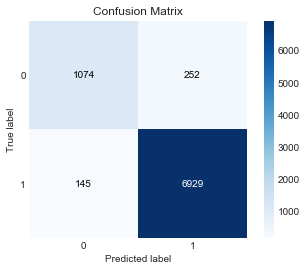

In [17]:

skplt.plot_confusion_matrix(y_test ,predicted)

In [18]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

Accuracy on test set: 95.274%
Precision on test set: 0.965
Recall on test set: 0.980
F1-Score on test set: 0.972


L2 regularization and finding alpha using grid search

best C =  {'C': 0.01}


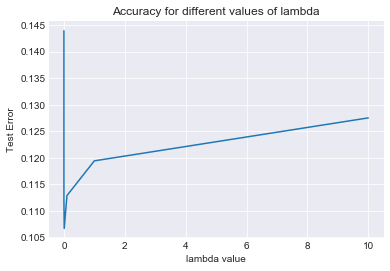

In [19]:
paramgrid = [{ 'C':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1]}]
optimalg = grid_alpha(normalised_bow_train,y_train,paramgrid,l2)

In [20]:
logreg = LogisticRegression(C = optimalg)

logreg.fit(normalised_bow_train,y_train)

predicted = logreg.predict(normalised_bow_test)

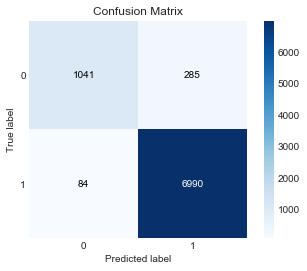

In [21]:

skplt.plot_confusion_matrix(y_test ,predicted)

In [22]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

Accuracy on test set: 95.607%
Precision on test set: 0.961
Recall on test set: 0.988
F1-Score on test set: 0.974


L2 regularization and finding alpha using random search

best C =  {'C': 0.02377205170844865}
Best Score on train data =  89.04761904761904


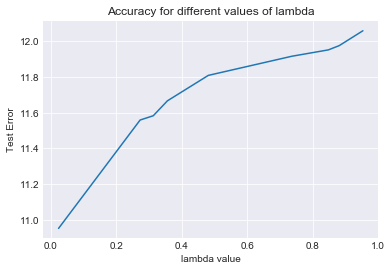

In [23]:
rand={'C':uniform()}
optimall=randomsearch_alpha(normalised_bow_train,y_train,rand,l2)

In [24]:
logreg = LogisticRegression(C = optimalg)

logreg.fit(normalised_bow_train,y_train)

predicted = logreg.predict(normalised_bow_test)

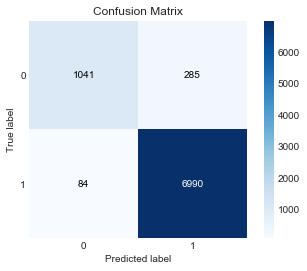

In [25]:
skplt.plot_confusion_matrix(y_test ,predicted)

In [26]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

Accuracy on test set: 95.607%
Precision on test set: 0.961
Recall on test set: 0.988
F1-Score on test set: 0.974


Checking effect of lambda on Sparsity

In [27]:
C_sparse = [0.01,0.1,1,10, 100]

In [28]:
spc = [] # Counts number of non zero weights for a given C.
error = [] # This wll store error for each val of C
for c in C_sparse:
    model = LogisticRegression(penalty='l1', C=c)
    model.fit(normalised_bow_train, y_train)
    error.append(1- model.score(normalised_bow_test, y_test))
    spc.append(np.count_nonzero(model.coef_))

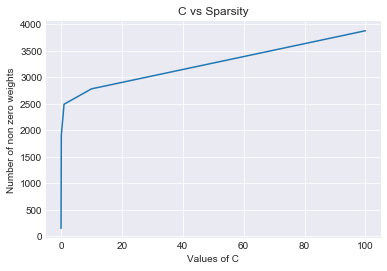

In [29]:
# Plotting C vs Sparsity
plt.title("C vs Sparsity")
plt.xlabel("Values of C")
plt.ylabel("Number of non zero weights")
plt.plot(C_sparse, spc)
plt.show()

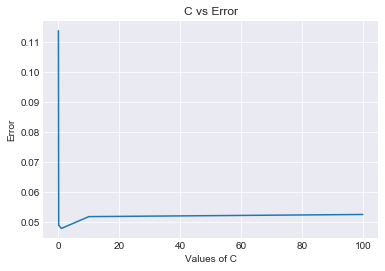

In [30]:
# Plotting C vs Error.
plt.title("C vs Error")
plt.xlabel("Values of C")
plt.ylabel("Error")
plt.plot(C_sparse, error)
plt.show()


6.Find feature importance

Pertubation test

In [31]:
# Adding small noise to train data.
epsilon = 0.05
per_train = normalised_bow_train.todense()
per_train_2 = per_train + epsilon


In [32]:
# training Logistic Regression on this new modified dataset.
model1 = LogisticRegression()
model1.fit(per_train_2, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
model2 = LogisticRegression()
model2.fit(per_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [34]:
model2.coef_ - model1.coef_

array([[ 0.00507603, -0.00064281, -0.00814079, ...,  0.00138551,
        -0.00040165, -0.00014972]])

Since we are observing a small difference between wieghts, features are not multicollinear

Feature Importance

In [35]:
features = pd.DataFrame(data=model2.coef_.reshape(-1,1), index=count_vect.get_feature_names())
features[0] = features[0].abs()
features.sort_values(by = 0, ascending=False).head(10)

,0
great,1.119062
love,1.040005
best,0.960666
excel,0.796479
good,0.751829
horribl,0.630401
disappoint,0.609853
enjoy,0.609798
wonder,0.582371
favorit,0.547418


Tf-Idf

In [36]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vec = TfidfVectorizer()
tfidf_model = tf_idf_vec.fit(X_train['CleanedText'])
final_tfidf_train = tfidf_model.transform(X_train['CleanedText'])
final_tfidf_test = tfidf_model.transform(X_test['CleanedText'])

In [37]:
normalised_tfidf_train = StandardScaler(with_mean=False).fit_transform(final_tfidf_train)
normalised_tfidf_test = StandardScaler(with_mean=False).fit_transform(final_tfidf_test)

best C =  {'C': 0.1}


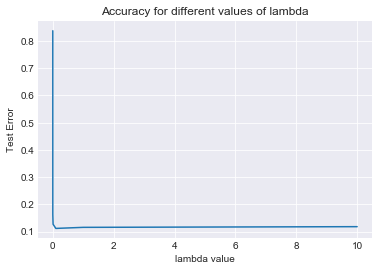

In [38]:
paramgrid = [{ 'C':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1]}]
optimalg = grid_alpha(normalised_tfidf_train,y_train,paramgrid,l1)

In [39]:
logreg = LogisticRegression(C = optimalg)

logreg.fit(normalised_tfidf_train,y_train)

predicted = logreg.predict(normalised_tfidf_test)

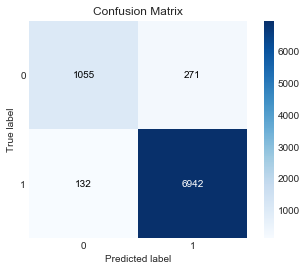

In [40]:
skplt.plot_confusion_matrix(y_test ,predicted)

In [41]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

Accuracy on test set: 95.202%
Precision on test set: 0.962
Recall on test set: 0.981
F1-Score on test set: 0.972


best C =  {'C': 0.08113003932103569}
Best Score on train data =  89.11904761904762


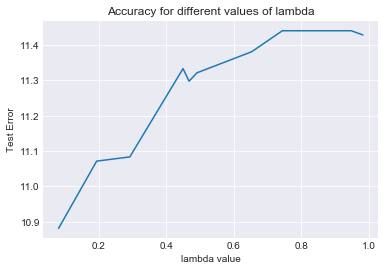

In [42]:
rand={'C':uniform()}
optimall=randomsearch_alpha(normalised_tfidf_train,y_train,rand,l1)

In [43]:
logreg = LogisticRegression(C = optimall)

logreg.fit(normalised_tfidf_train,y_train)

predicted = logreg.predict(normalised_tfidf_test)

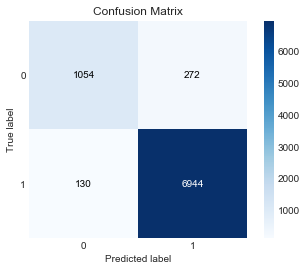

In [44]:
skplt.plot_confusion_matrix(y_test ,predicted)

In [45]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

Accuracy on test set: 95.214%
Precision on test set: 0.962
Recall on test set: 0.982
F1-Score on test set: 0.972


best C =  {'C': 0.01}


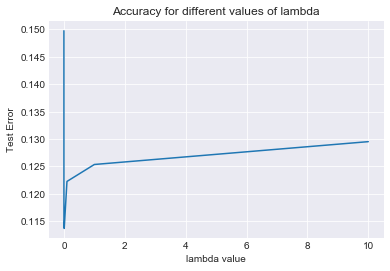

In [46]:
paramgrid = [{ 'C':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1]}]
optimalg = grid_alpha(normalised_tfidf_train,y_train,paramgrid,l2)

In [47]:
logreg = LogisticRegression(C = optimalg)

logreg.fit(normalised_tfidf_train,y_train)

predicted = logreg.predict(normalised_tfidf_test)

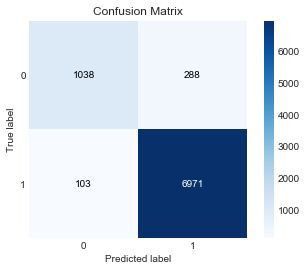

In [48]:
skplt.plot_confusion_matrix(y_test ,predicted)

In [49]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

Accuracy on test set: 95.345%
Precision on test set: 0.960
Recall on test set: 0.985
F1-Score on test set: 0.973


best C =  {'C': 0.029741444465689604}
Best Score on train data =  87.92857142857143


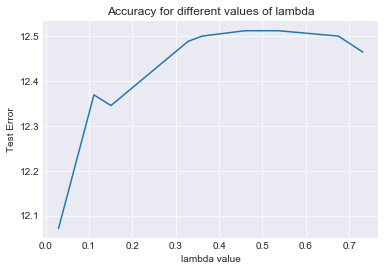

In [50]:
rand={'C':uniform()}
optimall=randomsearch_alpha(normalised_tfidf_train,y_train,rand,l2)

In [51]:
logreg = LogisticRegression(C = optimall)

logreg.fit(normalised_tfidf_train,y_train)

predicted = logreg.predict(normalised_tfidf_test)

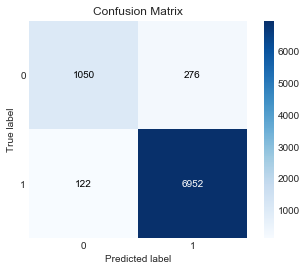

In [52]:
skplt.plot_confusion_matrix(y_test ,predicted)

In [53]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

Accuracy on test set: 95.262%
Precision on test set: 0.962
Recall on test set: 0.983
F1-Score on test set: 0.972


In [54]:
C_sparse = [0.01,0.1,1,10, 100]

In [55]:
spc = [] # Counts number of non zero weights for a given C.
error = [] # This wll store error for each val of C
for c in C_sparse:
    model = LogisticRegression(penalty='l1', C=c)
    model.fit(normalised_tfidf_train, y_train)
    error.append(1- model.score(normalised_tfidf_train, y_test))
    spc.append(np.count_nonzero(model.coef_))

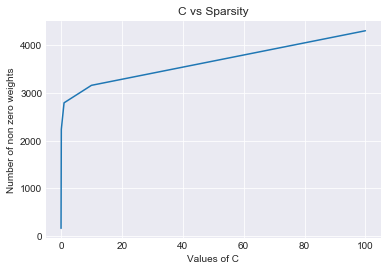

In [56]:
# Plotting C vs Sparsity
plt.title("C vs Sparsity")
plt.xlabel("Values of C")
plt.ylabel("Number of non zero weights")
plt.plot(C_sparse, spc)
plt.show()

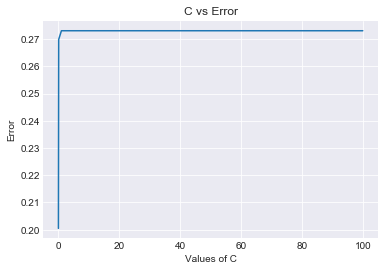

In [57]:
# Plotting C vs Error.
plt.title("C vs Error")
plt.xlabel("Values of C")
plt.ylabel("Error")
plt.plot(C_sparse, error)
plt.show()


In [58]:
# Adding small noise to train data.
epsilon = 0.05
per_train = normalised_tfidf_train.todense()
per_train_2 = per_train + epsilon

In [59]:
model1 = LogisticRegression()
model1.fit(per_train_2, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [60]:
model2 = LogisticRegression()
model2.fit(per_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [61]:
model2.coef_ - model1.coef_

array([[ 0.0032078 , -0.00601089, -0.00661891, ...,  0.00208565,
        -0.00672535, -0.00805738]])

Avg Word2Vec

In [62]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim

In [63]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
import nltk
from nltk.corpus import stopwords

stop = set(stopwords.words('english')) #set of stopwords
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [64]:
i=0
str1=''
list_of_sent_train=[]
final_string_for_tfidf_train = []
for sent in X_train['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    str1 = ''
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (cleaned_words.lower() not in stop)):    
                filtered_sentence.append(cleaned_words.lower())
                str1 += " "+cleaned_words.lower() 
            else:
                continue
  
    list_of_sent_train.append(filtered_sentence)
    final_string_for_tfidf_train.append((str1).strip())

In [65]:
i=0
str1=''
list_of_sent=[]
final_string_for_tfidf = []
for sent in sampled_data['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    str1 = ''
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (cleaned_words.lower() not in stop)):    
                filtered_sentence.append(cleaned_words.lower())
                str1 += " "+cleaned_words.lower() 
            else:
                continue
  
    list_of_sent.append(filtered_sentence)
    final_string_for_tfidf.append((str1).strip())

In [66]:
w2v_model=gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=50, workers=2)

In [67]:
sent_vectors = []; 
for sent in list_of_sent: 
    sent_vec = np.zeros(50)
    cnt_words =0; 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [68]:
X_train = sent_vectors[:math.ceil(len(sampled_data)*.7)]  #final_w2v_count
X_test = sent_vectors[math.ceil(len(sampled_data)*.3):] #final_w2v_count

In [69]:
X_train=np.nan_to_num(X_train)
X_test=np.nan_to_num(X_test)

In [70]:
normalised_w2v_train = StandardScaler(with_mean=False).fit_transform(X_train)
normalised_w2v_test = StandardScaler(with_mean=False).fit_transform(X_test)

best C =  {'C': 10}


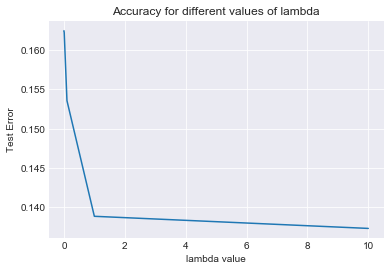

In [71]:
paramgrid = [{ 'C':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1]}]
optimalg = grid_alpha(normalised_w2v_train,y_train,paramgrid,l1)

In [72]:
logreg = LogisticRegression(C = optimalg)

logreg.fit(normalised_w2v_train,y_train)

predicted = logreg.predict(normalised_w2v_test)

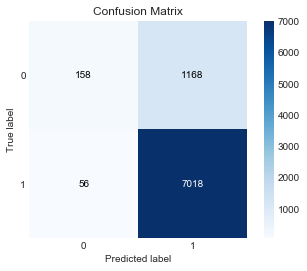

In [73]:
skplt.plot_confusion_matrix(y_test ,predicted)

In [74]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

Accuracy on test set: 85.429%
Precision on test set: 0.857
Recall on test set: 0.992
F1-Score on test set: 0.920


best C =  {'C': 0.9879584727213933}
Best Score on train data =  85.94047619047619


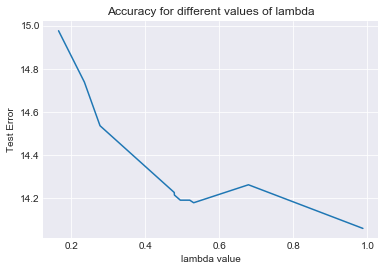

In [75]:
rand={'C':uniform()}
optimall=randomsearch_alpha(normalised_w2v_train,y_train,rand,l1)

In [76]:
logreg = LogisticRegression(C = optimall)

logreg.fit(normalised_w2v_train,y_train)

predicted = logreg.predict(normalised_w2v_test)

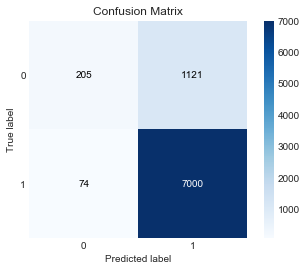

In [77]:
skplt.plot_confusion_matrix(y_test ,predicted)

In [78]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

Accuracy on test set: 85.774%
Precision on test set: 0.862
Recall on test set: 0.990
F1-Score on test set: 0.921


best C =  {'C': 10}


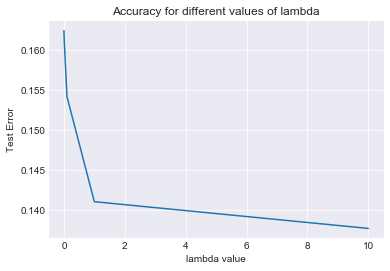

Accuracy on test set: 85.429%
Precision on test set: 0.857
Recall on test set: 0.992
F1-Score on test set: 0.920


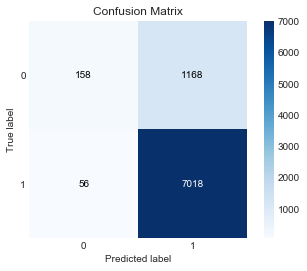

In [79]:
paramgrid = [{ 'C':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1]}]
optimalg = grid_alpha(normalised_w2v_train,y_train,paramgrid,l2)

logreg = LogisticRegression(C = optimalg)

logreg.fit(normalised_w2v_train,y_train)

predicted = logreg.predict(normalised_w2v_test)
skplt.plot_confusion_matrix(y_test ,predicted)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

best C =  {'C': 0.8942816660087962}
Best Score on train data =  85.79761904761905


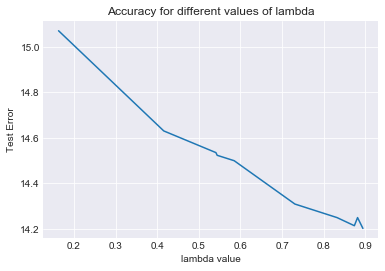

Accuracy on test set: 85.429%
Precision on test set: 0.857
Recall on test set: 0.992
F1-Score on test set: 0.920


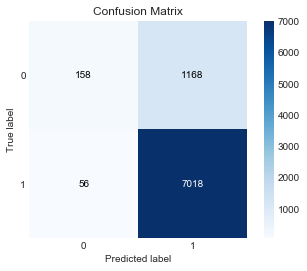

In [80]:
rand={'C':uniform()}
optimall=randomsearch_alpha(normalised_w2v_train,y_train,rand,l2)
logreg = LogisticRegression(C = optimalg)

logreg.fit(normalised_w2v_train,y_train)

predicted = logreg.predict(normalised_w2v_test)
skplt.plot_confusion_matrix(y_test ,predicted)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

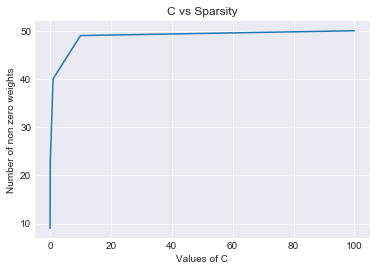

In [81]:
C_sparse = [0.01,0.1,1,10, 100]
spc = [] # Counts number of non zero weights for a given C.
error = [] # This wll store error for each val of C
for c in C_sparse:
    model = LogisticRegression(penalty='l1', C=c)
    model.fit(normalised_w2v_train, y_train)
    error.append(1- model.score(normalised_w2v_train, y_test))
    spc.append(np.count_nonzero(model.coef_))
    
# Plotting C vs Sparsity
plt.title("C vs Sparsity")
plt.xlabel("Values of C")
plt.ylabel("Number of non zero weights")
plt.plot(C_sparse, spc)
plt.show()

tf-idf weighted w2v

In [82]:
tf_idf_w2v = TfidfVectorizer()
tfidf_model = tf_idf_w2v.fit(final_string_for_tfidf_train)
final_tfidf_w=tfidf_model.transform(final_string_for_tfidf)

In [83]:
tfidf_feat = tf_idf_w2v.get_feature_names()


tfidf_sent_vectors = [];
row=0;
for sent in list_of_sent:  
    sent_vec = np.zeros(50) 
    weight_sum =0;
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tf_idf = final_tfidf_w[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except Exception as e: 
            pass #print(e)
            
    try:
        sent_vec /= weight_sum
    except:
        print(e)
        
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [84]:
X_train = tfidf_sent_vectors[:math.ceil(len(sampled_data)*.7)]  #final_w2v_count
X_test = tfidf_sent_vectors[math.ceil(len(sampled_data)*.3):] #final_w2v_count

In [85]:
X_train=np.nan_to_num(X_train)
X_test=np.nan_to_num(X_test)

In [86]:
normalised_tfidf_train = StandardScaler(with_mean=False).fit_transform(X_train)
normalised_tfidf_test = StandardScaler(with_mean=False).fit_transform(X_test)

In [87]:
logreg = LogisticRegression(C = optimalg)

logreg.fit(normalised_tfidf_train,y_train)

predicted = logreg.predict(normalised_tfidf_test)

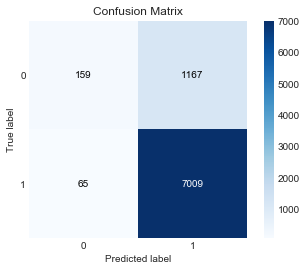

In [88]:
skplt.plot_confusion_matrix(y_test ,predicted)

In [89]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

Accuracy on test set: 85.333%
Precision on test set: 0.857
Recall on test set: 0.991
F1-Score on test set: 0.919


best C =  {'C': 0.9017190397544036}
Best Score on train data =  85.27380952380952


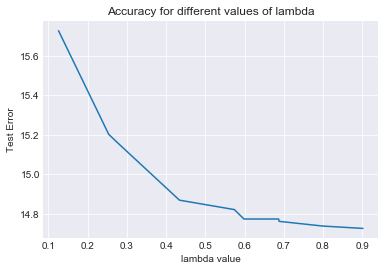

In [90]:
rand={'C':uniform()}
optimall=randomsearch_alpha(normalised_tfidf_train,y_train,rand,l1)

In [91]:
logreg = LogisticRegression(C = optimall)

logreg.fit(normalised_tfidf_train,y_train)

predicted = logreg.predict(normalised_tfidf_test)

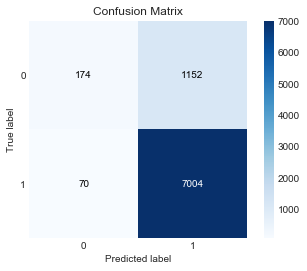

In [92]:
skplt.plot_confusion_matrix(y_test ,predicted)

In [93]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

Accuracy on test set: 85.452%
Precision on test set: 0.859
Recall on test set: 0.990
F1-Score on test set: 0.920


best C =  {'C': 10}


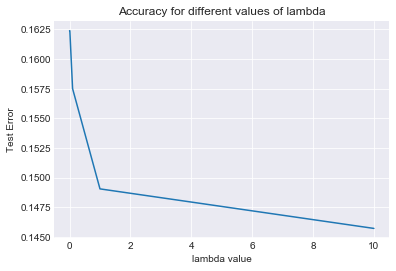

Accuracy on test set: 85.333%
Precision on test set: 0.857
Recall on test set: 0.991
F1-Score on test set: 0.919


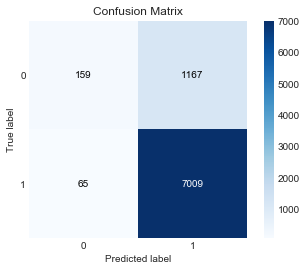

In [94]:
paramgrid = [{ 'C':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1]}]
optimalg = grid_alpha(normalised_tfidf_train,y_train,paramgrid,l2)

logreg = LogisticRegression(C = optimalg)

logreg.fit(normalised_tfidf_train,y_train)

predicted = logreg.predict(normalised_tfidf_test)
skplt.plot_confusion_matrix(y_test ,predicted)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

best C =  {'C': 0.9792983269072542}
Best Score on train data =  85.08333333333333


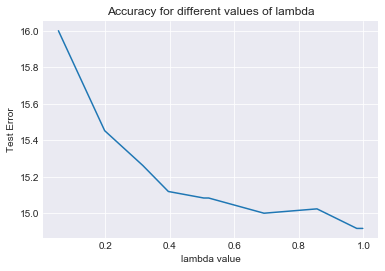

Accuracy on test set: 85.333%
Precision on test set: 0.857
Recall on test set: 0.991
F1-Score on test set: 0.919


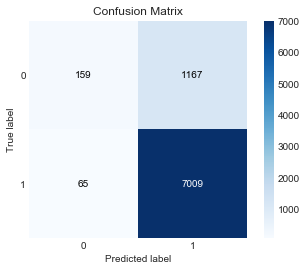

In [95]:
rand={'C':uniform()}
optimall=randomsearch_alpha(normalised_tfidf_train,y_train,rand,l2)
logreg = LogisticRegression(C = optimalg)

logreg.fit(normalised_tfidf_train,y_train)

predicted = logreg.predict(normalised_tfidf_test)
skplt.plot_confusion_matrix(y_test ,predicted)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, predicted)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, predicted)))
print("Recall on test set: %0.3f"%(recall_score(y_test, predicted)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, predicted)))

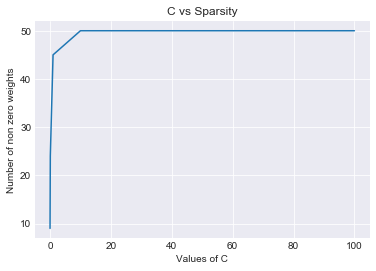

In [96]:
C_sparse = [0.01,0.1,1,10, 100]
spc = [] # Counts number of non zero weights for a given C.
error = [] # This wll store error for each val of C
for c in C_sparse:
    model = LogisticRegression(penalty='l1', C=c)
    model.fit(normalised_tfidf_train, y_train)
    error.append(1- model.score(normalised_tfidf_train, y_test))
    spc.append(np.count_nonzero(model.coef_))
    
# Plotting C vs Sparsity
plt.title("C vs Sparsity")
plt.xlabel("Values of C")
plt.ylabel("Number of non zero weights")
plt.plot(C_sparse, spc)
plt.show()